In [10]:
import spikeinterface as si
import spikeinterface.core as sc
import spikeinterface.extractors as se
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from math import dist
from spikeinterface.preprocessing import BandpassFilterRecording
from spikeinterface.core import get_template_extremum_channel
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.hs_detection import hs_detect
from spikeinterface.sortingcomponents.old_hs_detection import old_hs_detect
from ipywidgets import FloatProgress, Layout
from IPython.display import display
import spikeforest as sf
# Helper function for suppressing output
import sys
import io
import contextlib

In [5]:
@contextlib.contextmanager
def silence():
    sys.stdout, old = io.StringIO(), sys.stdout
    try:
        yield
    finally:
        sys.stdout = old

In [6]:
remote_path = "ephy_testing_data/mearec/mearec_test_10s.h5"
dataset_path = Path(Path.home() / "school" / "MINF2" / "datasets" / remote_path)

if "mearec" in remote_path:
    recording = se.MEArecRecordingExtractor(dataset_path)
    sorting_gt = se.MEArecSortingExtractor(dataset_path)
else:
    raise Exception("Unknown dataset")

In [19]:
filtered_recording = BandpassFilterRecording(recording, freq_min=300.0, freq_max=6000.0)

rec_folder = Path(f"./filtered_rec/{remote_path}/")
if rec_folder.exists():
    filtered_recording = si.load_extractor(rec_folder)
else:
    filtered_recording = filtered_recording.save(
        folder=rec_folder,
        n_jobs=10,
        chunk_size=30000,
        progress_bar=True,
    )

In [20]:
wf_folder = Path(f"extracted_waveforms/{remote_path}")
if wf_folder.exists():
    we = si.load_waveforms(wf_folder)
else:
    we = si.extract_waveforms(
        filtered_recording,
        sorting_gt,
        mode="folder",
        folder=wf_folder,
        progress_bar=True,
        n_jobs=10,
        total_memory="5000M",
        chunk_duration="1s",
        overwrite=False
    )

In [21]:
# Precomputations
extremum_channels_inds = get_template_extremum_channel(
    we, peak_sign="neg", outputs="index"
)

unique_extremum_chs = np.unique(list(extremum_channels_inds.values()))

# Map unit inds to their mutual extremum channel
extremum_ch_to_units_inds = {}
for ch in unique_extremum_chs:
    extremum_ch_to_units_inds[ch] = [
        np.where(sorting_gt.get_unit_ids() == k)[0][0]
        for k, v in extremum_channels_inds.items()
        if v == ch
    ]

# Map a group of gt units to their mutual extremum channel
sorting_gt_groups = {}
for ch, unit_inds in extremum_ch_to_units_inds.items():
    gt_units_spike_train = [
        sorting_gt.get_unit_spike_train(unit_id=sorting_gt.get_unit_ids()[unit_ind])
        for unit_ind in unit_inds
    ]
    merged_units = np.concatenate(gt_units_spike_train)
    merged_units.sort(kind="stable")
    sorting_gt_groups[ch] = merged_units

In [22]:
def run_detection(
    recording, method, threshold, neighbor_radius=90.0, verbose=True, disk=False, **kwargs
):
    if method == "hs_detection":
        peak_dir = Path("./hs_detection_peaks")
        peak_subdir = Path(f"{peak_dir}/{remote_path}")
        if (
            not peak_subdir.is_dir()
            or not (peak_subdir / f"{threshold}_{neighbor_radius}.npy").exists()
            or disk == False
        ):
            if disk:
                os.makedirs(peak_subdir, exist_ok=True)
            # print(f"running {method} with threshold: {threshold} and neighbor_radius: {neighbor_radius}...")
            # print(f"{filtered_recording.get_num_frames()} frames in recording")
            peaks = hs_detect(
                recording=filtered_recording,
                bandpass=False,
                save_shape=False,
                threshold=threshold,
                verbose=False,
                neighbor_radius=neighbor_radius,
                **kwargs,
            )
            if verbose:
                # print(f"{type(peaks)}; {peaks}")
                print(f"{peaks.size} peaks detected! threshold: {threshold}")
            if disk:
                np.save(peak_subdir / f"{threshold}_{neighbor_radius}.npy", peaks)
                if verbose:
                    print(f"peaks saved to disk!")
        elif disk:
            peaks = np.load(peak_subdir / f"{threshold}_{neighbor_radius}.npy")
            if verbose:
                print(f"{peaks.size} peaks loaded from disk! threshold: {threshold}")
    elif method == "old_hs_detection":
        peak_dir = Path("./old_hs_detection_peaks")
        peak_subdir = Path(f"{peak_dir}/{remote_path}")
        detected_peaks_file = f"old_HS2_detected_{threshold}"
        detected_peaks_file_path = Path(f"{peak_subdir}/{detected_peaks_file}.bin")
        if not peak_subdir.is_dir() or not detected_peaks_file_path.is_file():
            os.makedirs(peak_subdir, exist_ok=True)
        else:
            if verbose:
                print(f"peaks found on disk!")
        with silence():
            peaks = old_hs_detect(
                recording=filtered_recording,
                bandpass=False,
                to_localize=False,
                detect_threshold=threshold,
                out_file_name=f"{peak_subdir}/{detected_peaks_file}",
            )
        if verbose:
            print(f"{len(peaks['sample_ind'])} peaks detected! threshold: {threshold}")
    elif method == "peak_detection_le":
        noise_levels = sc.recording_tools.get_noise_levels(
            recording, return_scaled=False
        )
        peak_dir = Path("./peak_detection_le_peaks")
        peak_subdir = Path(f"{peak_dir}/{remote_path}")
        if not peak_subdir.is_dir() or not (peak_subdir / f"{threshold}.npy").exists():
            os.makedirs(peak_subdir, exist_ok=True)
            peaks = detect_peaks(
                recording,
                detect_threshold=threshold,
                method="locally_exclusive",
                local_radius_um=100,
                peak_sign="neg",
                # n_shifts=10,
                noise_levels=noise_levels,
                n_jobs=10,
                chunk_duration="1s",
            )
            if verbose:
                print(f"{peaks.size} peaks detected! threshold: {threshold}")
            np.save(peak_subdir / f"{threshold}.npy", peaks)
            if verbose:
                print(f"peaks saved to disk!")
        else:
            peaks = np.load(peak_subdir / f"{threshold}.npy")
            if verbose:
                print(f"{peaks.size} peaks loaded from disk! threshold: {threshold}")
    elif method == "peak_detection_ch":
        peak_dir = Path("./peak_detection_ch_peaks")
        peak_subdir = Path(f"{peak_dir}/{remote_path}")
        if not peak_subdir.is_dir() or not (peak_subdir / f"{threshold}.npy").exists():
            os.makedirs(peak_subdir, exist_ok=True)
            peaks = detect_peaks(
                recording,
                detect_threshold=threshold,
                method="by_channel",
                n_jobs=10,
                chunk_duration="1s",
            )
            if verbose:
                print(f"{peaks.size} peaks detected! threshold: {threshold}")
            np.save(peak_subdir / f"{threshold}.npy", peaks)
            if verbose:
                print(f"peaks saved to disk!")
        else:
            peaks = np.load(peak_subdir / f"{threshold}.npy")
            if verbose:
                print(f"{peaks.size} peaks loaded from disk! threshold: {threshold}")
    return peaks

In [23]:
def plot_metrics(thresholds, accuracies, precisions, recalls):
    plt.plot(thresholds, accuracies, label="accuracy", marker="o", color="g")
    plt.plot(thresholds, precisions, label="precision", marker="s", color="r")
    plt.plot(thresholds, recalls, label="recall", marker="x", color="b")
    plt.xlabel("Threshold")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


In [24]:
def get_channels_in_radius(probe, radius, ch_ind):
    chs = {}
    ch_locs = probe.contact_positions
    for ind, ch_loc in enumerate(ch_locs):
        distance = dist(ch_locs[ch_ind], ch_loc)
        if distance <= radius:
            chs[ind] = distance
    return chs


In [25]:
def run(
    recording,
    sorting,
    radius,
    jitter,
    detection_method,
    thresholds,
    neighbor_radius=90.0,
    verbose=True,
    plot=True,
    progress=True,
    **kwargs,
):
    if not isinstance(thresholds, list):
        thresholds = [thresholds]
    
    _gt_peaks = sum(
        [
            len(sorting.get_unit_spike_train(unit) / recording.get_sampling_frequency())
            for unit in sorting.get_unit_ids()
        ]
    )
    _total_gt_peaks = _gt_peaks * len(thresholds)
    progress_bar = FloatProgress(
        min=0, max=_total_gt_peaks, bar_style="info", layout=Layout(width="99%")
    )
    if progress:
        display(progress_bar)

    accuracies, precisions, recalls = [], [], []
    for threshold in thresholds:
        peaks = run_detection(
            recording=recording,
            method=detection_method,
            threshold=threshold,
            neighbor_radius=neighbor_radius,
            verbose=verbose,
            **kwargs,
        )
        matched_gt_peaks = 0
        matched_detected_peaks = 0
        duplicate_detected_peaks = 0
        already_marked_detected_peaks = 0
        equal_t_same_channel = 0
        marked = np.full(peaks.size, False)

        for extremum_ch, gt_units_group in sorting_gt_groups.items():
            gt_peaks_t = gt_units_group / recording.get_sampling_frequency()
            chs = get_channels_in_radius(
                probe=recording.get_probe(), radius=radius, ch_ind=extremum_ch
            )
            ch_inds = list(chs.keys())
            peaks_chs_filter = np.isin(peaks["channel_ind"], ch_inds)
            peaks_subset = peaks[peaks_chs_filter]
            detected_peaks_t = (
                peaks_subset["sample_ind"] / recording.get_sampling_frequency()
            )
            detected_peaks_ch = peaks_subset["channel_ind"]
            detected_peaks_inds = np.where(peaks_chs_filter == True)[0]
            for gt_peak_t in gt_peaks_t:
                dt = abs(np.subtract(gt_peak_t, detected_peaks_t))
                within_jitter = np.where(dt <= jitter)
                matched_chs = np.unique(detected_peaks_ch[within_jitter])
                if len(matched_chs) > 0:
                    matched_gt_peaks += 1
                    # If spikes are within jitter on multiple channels, count duplicates
                    if len(matched_chs) > 1:
                        duplicate_detected_peaks += len(matched_chs) - 1
                for matched_ch in matched_chs:
                    matched_ch_filter = np.where(
                        detected_peaks_ch[within_jitter] == matched_ch
                    )
                    ch_filtered_dt = dt[within_jitter][matched_ch_filter]
                    # Get the minimum of the valid differences on this current matched_ch and mark it.
                    # dt[within_jitter] indices of elements matching the minimum difference for the current channel (could be multiple from multiple channels)
                    dt_min_inds = np.where(dt[within_jitter] == np.min(ch_filtered_dt))
                    # dt[within_jitter] indices of elements from the current channel matching the minimum difference for the current channel (could be multiple from the same channel)
                    dt_min_inds_ch_filtered = dt_min_inds[0][
                        np.where(
                            detected_peaks_ch[within_jitter][dt_min_inds] == matched_ch
                        )
                    ]
                    if len(dt_min_inds_ch_filtered) > 1:
                        equal_t_same_channel += 1
                    # If there are multiple equal spike times on the same channel, only select one and attempt to select unmarked.
                    for min_ind in dt_min_inds_ch_filtered:
                        dt_min_ind = within_jitter[0][min_ind]
                        if marked[detected_peaks_inds[dt_min_ind]] == False:
                            break
                    assert detected_peaks_ch[dt_min_ind] == matched_ch
                    assert (
                        peaks["sample_ind"][detected_peaks_inds[dt_min_ind]]
                        / recording.get_sampling_frequency()
                        == detected_peaks_t[dt_min_ind]
                    )
                    assert (
                        peaks["channel_ind"][detected_peaks_inds[dt_min_ind]]
                        == detected_peaks_ch[dt_min_ind]
                    )
                    if marked[detected_peaks_inds[dt_min_ind]] == True:
                        already_marked_detected_peaks += 1
                    marked[detected_peaks_inds[dt_min_ind]] = True
                    matched_detected_peaks += 1
            progress_bar.value += len(gt_peaks_t)
        if verbose:
            print(
                f"""
gt peaks:                       {_gt_peaks},
detected peaks:                 {len(peaks)} -- {100 * len(peaks) / _gt_peaks:.2f}% of gt peaks,
matched gt peaks:               {matched_gt_peaks} -- {100 * matched_gt_peaks / _gt_peaks:.2f}% of gt peaks,
matched detected peaks:         {matched_detected_peaks} -- {100 * matched_detected_peaks / len(peaks):.2f}% of detected peaks,
duplicate detected peaks:       {duplicate_detected_peaks} -- {100 * duplicate_detected_peaks / matched_detected_peaks:.2f}% of matched detected peaks,
unmatched detected peaks:       {len(peaks) - matched_detected_peaks} -- {100 * (len(peaks) - matched_detected_peaks) / len(peaks):.2f}% of detected peaks,              
already matched detected peaks: {already_marked_detected_peaks} -- {100 * already_marked_detected_peaks / matched_detected_peaks:.2f}% of matched detected peaks,
equal peak times same channel:  {equal_t_same_channel}"""
            )

        recall = matched_gt_peaks / (matched_gt_peaks + (_gt_peaks - matched_gt_peaks))
        precision = matched_gt_peaks / (
            matched_gt_peaks + (len(peaks) - matched_detected_peaks)
        )
        accuracy = matched_gt_peaks / (
            matched_gt_peaks
            + (_gt_peaks - matched_gt_peaks)
            + (len(peaks) - matched_detected_peaks)
        )
        if verbose:
            print(
                f"""
threshold: {threshold}, 
accuracy:  {accuracy:.2f},
precision: {precision:.2f}, 
recall:    {recall:.2f}
----------\n"""
            )
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
    if plot:
        plot_metrics(thresholds, accuracies, precisions, recalls)
    else:
        return accuracies, precisions, recalls


FloatProgress(value=0.0, bar_style='info', layout=Layout(width='99%'), max=8217.0)

53500 peaks loaded from disk! threshold: 2

gt peaks:                       747,
detected peaks:                 53500 -- 7161.98% of gt peaks,
matched gt peaks:               743 -- 99.46% of gt peaks,
matched detected peaks:         873 -- 1.63% of detected peaks,
duplicate detected peaks:       130 -- 14.89% of matched detected peaks,
unmatched detected peaks:       52627 -- 98.37% of detected peaks,              
already matched detected peaks: 0 -- 0.00% of matched detected peaks,
equal peak times same channel:  0

threshold: 2, 
accuracy:  0.01,
precision: 0.01, 
recall:    0.99
----------

7737 peaks loaded from disk! threshold: 3

gt peaks:                       747,
detected peaks:                 7737 -- 1035.74% of gt peaks,
matched gt peaks:               743 -- 99.46% of gt peaks,
matched detected peaks:         846 -- 10.93% of detected peaks,
duplicate detected peaks:       103 -- 12.17% of matched detected peaks,
unmatched detected peaks:       6891 -- 89.07% of detecte

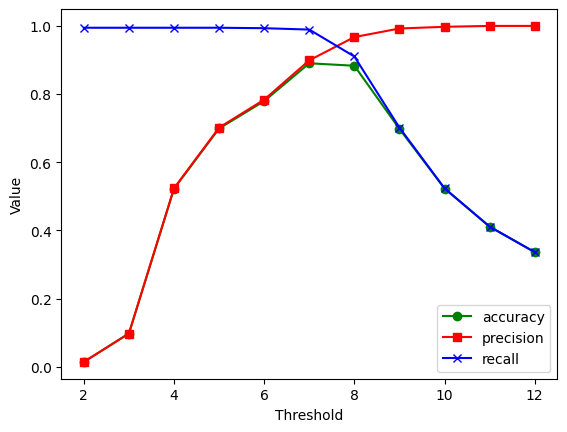

In [26]:
run(
    recording=filtered_recording,
    sorting=sorting_gt,
    radius=30,
    jitter=0.0004,
    detection_method="peak_detection_le",
    thresholds=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    verbose=True,
    plot=True,
    progress=True,
)


In [ ]:
run(
    recording=filtered_recording,
    sorting=sorting_gt,
    radius=30,
    jitter=0.0004,
    detection_method="peak_detection_ch",
    thresholds=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    verbose=False,
    plot=True,
    progress=False,
)


In [ ]:
run(
    recording=filtered_recording,
    sorting=sorting_gt,
    radius=30,
    jitter=0.0004,
    detection_method="old_hs_detection",
    thresholds=[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    verbose=False,
    plot=True,
    progress=False,
)


In [ ]:
run(
    recording=filtered_recording,
    sorting=sorting_gt,
    radius=30,
    jitter=0.0004,
    detection_method="hs_detection",
    thresholds=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    verbose=False,
    plot=True,
    progress=False,
)


In [ ]:
run(
    recording=filtered_recording,
    sorting=sorting_gt,
    radius=30,
    jitter=0.0004,
    detection_method="hs_detection",
    thresholds=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    neighbor_radius=0.0,
    verbose=False,
    plot=True,
    progress=False,
)


In [ ]:
import warnings

warnings.filterwarnings("ignore")

from skopt.space import Integer
from skopt.space import Real
from skopt.utils import use_named_args
from skopt import gp_minimize
import skopt

""" Optimising hs_detection
"""
# default neighbor_radius = 90.0
""" neighbor_radius = the spike with the maximum amplitude in the neighor_radius 
is selected as the center of its group; all others are filtered out.

"""
neighbor_radius_space = Real(0.0, 120.0, name="neighbor_radius", prior="uniform")
# default threshold = 10
thresholds_space = Integer(1, 20, name="thresholds", prior="uniform")
# default rescale_value = -1280.0
rescale_value_space = Real(-1680.0, -880.0, name="rescale_value", prior="uniform")
# default amp_avg_duration = 0.4
amp_avg_duration_space = Real(0.1, 0.7, name="amp_avg_duration", prior="uniform")
# default min_avg_amp = 5.0
min_avg_amp_space = Real(3.0, 7.0, name="min_avg_amp", prior="uniform")
# default inner_radius = 70.0
inner_radius_space = Real(0.0, 120.0, name="inner_radius", prior="uniform")


search_space = list()
search_space.append(thresholds_space)
search_space.append(neighbor_radius_space)


@use_named_args(search_space)
def evaluate_run(**params):
    accuracies, precisions, recalls = run(
        recording=filtered_recording,
        sorting=sorting_gt,
        radius=30,
        jitter=0.0004,
        detection_method="hs_detection",
        verbose=False,
        plot=False,
        progress=False,
        **params,
    )
    return 1.0 - np.mean(accuracies)


result = gp_minimize(
    evaluate_run,
    search_space,
    n_calls=30,
    n_random_starts=10,
    random_state=298374273,
)
accuracy = 1.0 - result.fun

print(f"Optimising for parameters:")
for i, param in enumerate(search_space):
    print(f"* {param.name}")
print("-----")
print("accuracy: %.6f" % accuracy)
parameters = result.x
optimal_threshold = parameters[0]
optimal_neighbor_radius = parameters[1]
_acc, precision, recall = run(
    recording=filtered_recording,
    sorting=sorting_gt,
    radius=30,
    jitter=0.0004,
    detection_method="hs_detection",
    thresholds=[optimal_threshold],
    neighbor_radius=optimal_neighbor_radius,
    verbose=False,
    plot=False,
    progress=False,
)
assert abs(_acc[0] - accuracy) < 1e-6
print(f"precision: {precision[0]:.6f}")
print(f"recall: {recall[0]:.6f}")

for i, param in enumerate(search_space):
    print(f"{param.name}: {parameters[i]:.6f}")
print(f"<====================================>")
optimised_search_space = list()
thresholds_space.low = optimal_threshold
thresholds_space.high = optimal_threshold
neighbor_radius_space.low = optimal_neighbor_radius
neighbor_radius_space.high = optimal_neighbor_radius

optimised_search_space.append(thresholds_space)
optimised_search_space.append(neighbor_radius_space)
optimised_search_space.append(inner_radius_space)
optimised_search_space.append(rescale_value_space)
optimised_search_space.append(amp_avg_duration_space)
optimised_search_space.append(min_avg_amp_space)


@use_named_args(optimised_search_space)
def _evaluate_run(**params):
    accuracies, precisions, recalls = run(
        recording=filtered_recording,
        sorting=sorting_gt,
        radius=30,
        jitter=0.0004,
        detection_method="hs_detection",
        verbose=False,
        plot=False,
        progress=False,
        **params,
    )
    return 1.0 - np.mean(accuracies)


optimised_result = gp_minimize(
    _evaluate_run,
    optimised_search_space,
    n_calls=30,
    n_random_starts=10,
    random_state=928374423,
)
accuracy = 1.0 - optimised_result.fun
parameters = optimised_result.x

optimised_parameters = dict()
for i, param in enumerate(optimised_search_space):
    if param.name == "thresholds" or param.name == "neighbor_radius":
        continue
    optimised_parameters[param.name] = parameters[i]

print(f"Optimising for parameters:")
for name, _ in optimised_parameters.items():
    print(f"* {name}")
print("---")
print("accuracy: %.6f" % accuracy)

_acc, precision, recall = run(
    recording=filtered_recording,
    sorting=sorting_gt,
    radius=30,
    jitter=0.0004,
    detection_method="hs_detection",
    thresholds=[optimal_threshold],
    neighbor_radius=optimal_neighbor_radius,
    verbose=False,
    plot=False,
    progress=False,
    **optimised_parameters,
)
assert abs(_acc[0] - accuracy) < 1e-6
print(f"precision: {precision[0]:.6f}")
print(f"recall: {recall[0]:.6f}")

for i, param in enumerate(optimised_search_space):
    print(f"{param.name}: {parameters[i]:.6f}")


In [ ]:
from skopt.plots import plot_objective
plot_objective(optimised_result)

In [ ]:
from skopt.plots import plot_convergence

plot_convergence(result)
